In [1]:
import numpy as np
import csv
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
        
    num_item, num_user = train.shape

    user_features = np.random.rand(num_features, num_user)
    item_features = np.random.rand(num_features, num_item)

    # start by item features.
    item_nnz = train.getnnz(axis=1)
    item_sum = train.sum(axis=1)

    for ind in range(num_item):
        item_features[0, ind] = item_sum[ind, 0] / item_nnz[ind]
    return user_features, item_features

In [3]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    mse = 0
    for row, col in nz:
        item_info = item_features[:, row]
        user_info = user_features[:, col]
        mse += (data[row, col] - user_info.T.dot(item_info)) ** 2
    return np.sqrt(1.0 * mse / len(nz))

In [4]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    """the best lambda is assumed to be nnz_items_per_user[user] * lambda_user"""
    num_user = nnz_items_per_user.shape[0]
    num_feature = item_features.shape[0]
    lambda_I = lambda_user * sp.eye(num_feature)
    updated_user_features = np.zeros((num_feature, num_user))

    for user, items in nz_user_itemindices:
        # extract the columns corresponding to the prediction for given item
        M = item_features[:, items]
        
        # update column row of user features
        V = M @ train[items, user]
        A = M @ M.T + nnz_items_per_user[user] * lambda_I
        X = np.linalg.solve(A, V)
        updated_user_features[:, user] = np.copy(X.T)
    return updated_user_features

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    """the best lambda is assumed to be nnz_items_per_item[item] * lambda_item"""
    num_item = nnz_users_per_item.shape[0]
    num_feature = user_features.shape[0]
    lambda_I = lambda_item * sp.eye(num_feature)
    updated_item_features = np.zeros((num_feature, num_item))

    for item, users in nz_item_userindices:
        # extract the columns corresponding to the prediction for given user
        M = user_features[:, users]
        V = M @ train[item, users].T
        A = M @ M.T + nnz_users_per_item[item] * lambda_I
        X = np.linalg.solve(A, V)
        updated_item_features[:, item] = np.copy(X.T)
    return updated_item_features

In [5]:
from itertools import groupby

def group_by(data, index):
    """group list of list by a specific index."""
    sorted_data = sorted(data, key=lambda x: x[index])
    groupby_data = groupby(sorted_data, lambda x: x[index])
    return groupby_data

In [6]:
def build_index_groups(train):
    """build groups for nnz rows and cols."""
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))

    grouped_nz_train_byrow = group_by(nz_train, index=0)
    nz_row_colindices = [(g, np.array([v[1] for v in value]))
                         for g, value in grouped_nz_train_byrow]

    grouped_nz_train_bycol = group_by(nz_train, index=1)
    nz_col_rowindices = [(g, np.array([v[0] for v in value]))
                         for g, value in grouped_nz_train_bycol]
    return nz_train, nz_row_colindices, nz_col_rowindices

In [7]:
def ALS(train):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.08
    lambda_item = 0.08
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    train = sp.csr_matrix(train)
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # get the number of non-zero ratings for each user and item
    nnz_items_per_user, nnz_users_per_item = train.getnnz(axis=0), train.getnnz(axis=1)
    
    # group the indices by row or column index
    nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(train)

    # run ALS
    print("\nstart the ALS algorithm...")
    while change > stop_criterion:
        # update user feature & item feature
        user_features = update_user_feature(
            train, item_features, lambda_user,
            nnz_items_per_user, nz_user_itemindices)
        item_features = update_item_feature(
            train, user_features, lambda_item,
            nnz_users_per_item, nz_item_userindices)

        error = compute_error(train, user_features, item_features, nz_train)
        print("RMSE on training set: {}.".format(error))
        error_list.append(error)
        change = np.fabs(error_list[-1] - error_list[-2])
        print(change)
    
    # evaluate the test error
    rmse = compute_error(train, user_features, item_features, nz_train)
    print("Train RMSE after running ALS: {v}.".format(v=rmse))
    
    return user_features.T @ item_features, rmse

In [8]:
def parser(path_csv) :
    maxUserId = 0
    maxMovieId = 0
    with open(path_csv, 'r') as csvfile:
        linereader = csv.reader(csvfile, delimiter = ',')
        next(linereader)
        
        for row in linereader:
            rx, cy = row[0].split('_')
            x, y = int(rx[1:]), int(cy[1:])
            maxUserId = max(maxUserId, x)
            maxMovieId = max(maxMovieId, y)
    sparse_matrix = np.zeros((maxUserId,maxMovieId))
    with open(path_csv, 'r') as csvfile:
        linereader = csv.reader(csvfile, delimiter = ',')
        next(linereader)
        for row in linereader:
            rx, cy = row[0].split('_')
            x, y = int(rx[1:]), int(cy[1:])
            sparse_matrix[x-1][y-1] = int(row[1])
    return sparse_matrix

In [9]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # init
    num_rows, num_cols = valid_ratings.shape
    train = sp.lil_matrix((num_rows, num_cols))
    test = sp.lil_matrix((num_rows, num_cols))
    
    print("the shape of original ratings. (# of row, # of col): {}".format(
        ratings.shape))
    print("the shape of valid ratings. (# of row, # of col): {}".format(
        (num_rows, num_cols)))

    nz_items, nz_users = valid_ratings.nonzero()
    
    # split the data
    for user in set(nz_users):
        # randomly select a subset of ratings
        row, col = valid_ratings[:, user].nonzero()
        selects = np.random.choice(row, size=int(len(row) * p_test))
        residual = list(set(row) - set(selects))

        # add to train set
        train[residual, user] = valid_ratings[residual, user]

        # add to test set
        test[selects, user] = valid_ratings[selects, user]

    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

In [10]:
def reverseParser(sparse_matrix, pathToSample, pathToFinal):
    ## given the sample submission, it will update the value of each line.
    
    with open(pathToSample, 'r') as csvfile, open(pathToFinal, 'w', newline='') as csvFinal:
        linereader = csv.reader(csvfile, delimiter =',')
        linewriter = csv.writer(csvFinal, delimiter =',')
        linewriter.writerow(["Id","Prediction"])
        next(linereader)
        for row in linereader:
            rx, cy = row[0].split('_')
            x, y = int(rx[1:]), int(cy[1:])
            rx_cy = "r"+str(x)+"_c"+str(y)
            if(sparse_matrix[x-1][y-1] < 1): sparse_matrix[x-1][y-1] = 1
            if(sparse_matrix[x-1][y-1] > 5): sparse_matrix[x-1][y-1] = 5
            linewriter.writerow([rx_cy, int(round(sparse_matrix[x-1][y-1]))])
    print("Writing is done")

In [11]:
### path to the data
path = "../data/"
file_to_read = "data_train.csv"
fileread = path + file_to_read
fileread
train = parser(fileread)

In [12]:
predicted, rmse = ALS(train)


start the ALS algorithm...
RMSE on training set: 1.048153205690883.
1.048153205690883
RMSE on training set: 1.014050177944071.
0.034103027746812176
RMSE on training set: 0.9768601371898459.
0.03719004075422505
RMSE on training set: 0.9503021006311955.
0.02655803655865041
RMSE on training set: 0.9349440324499755.
0.015358068181219986
RMSE on training set: 0.9259827076442098.
0.008961324805765725
RMSE on training set: 0.9202205977082003.
0.005762109936009452
RMSE on training set: 0.9161983467037053.
0.004022251004495048
RMSE on training set: 0.9132391529908327.
0.0029591937128725654
RMSE on training set: 0.9109832260336556.
0.0022559269571771345
RMSE on training set: 0.9092165084864704.
0.0017667175471851593
RMSE on training set: 0.9078025825487778.
0.0014139259376926283
RMSE on training set: 0.9066505202210835.
0.0011520623276942699
RMSE on training set: 0.9056976118169013.
0.0009529084041821623
RMSE on training set: 0.9048993572124056.
0.000798254604495785
RMSE on training set: 0.9042

Text(0,0.5,'Train error')

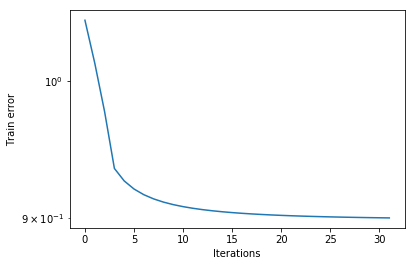

In [13]:
data = [1.048153205690883, 1.014050177944071, 0.9768601371898459, 0.9349440324499755, 0.9259827076442098, 0.9202205977082003, 
        0.9161983467037053, 0.9132391529908327, 0.9109832260336556, 0.9092165084864704,
        0.9078025825487778, 0.9066505202210835, 0.9056976118169013, 0.9048993572124056,
        0.9042233795795613, 0.9036455923644462, 0.9031477173080167, 0.9027156385258884,
        0.9023382865648899, 0.902006865204766, 0.9017143041164498, 0.9014548632276742,
        0.9012238410676461, 0.9010173558971505, 0.9008321788990398, 0.9006656053959452,
        0.9005153543932779, 0.9003794895802142, 0.9002563568119605, 0.900144534381065,
        0.9000427932834756, 0.8999500653310071]

pd.Series(data).plot(logy=True)
plt.xlabel("Iterations")
plt.ylabel("Train error")

In [14]:
pathout = "../reports/"
filename = "../data/sample_submission.csv"
totalFinal = path + "out"
totalFinal = totalFinal + ".csv"
reverseParser(predicted.T, filename, totalFinal)

Writing is done


In [15]:
'''path = "../data/"
filename = "sample_submission.csv"
totalSample = path + filename
totalFinal = path + "outFor"
train = sp.csr_matrix(train)
for i in range(1,10):
    predicted = ALS(train, (1.0/10.0**i))
    totalFinal = totalFinal + str(i) + ".csv"
    reverseParser(predicted.T, totalSample, totalFinal)'''


'path = "../data/"\nfilename = "sample_submission.csv"\ntotalSample = path + filename\ntotalFinal = path + "outFor"\ntrain = sp.csr_matrix(train)\nfor i in range(1,10):\n    predicted = ALS(train, (1.0/10.0**i))\n    totalFinal = totalFinal + str(i) + ".csv"\n    reverseParser(predicted.T, totalSample, totalFinal)'